# The EM algorithm

##### Keywords: maximum likelihood, mixture model, ELBO, full-data likelihood, x-likelihood, latent variables, log-likelihood, training set, normal distribution, z-posterior

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

$$\newcommand{\isum}{\sum_{i}}$$
$$\newcommand{\zsum}{\sum_{k=1}^{K}}$$
$$\newcommand{\zsumi}{\sum_{\{z_i\}}}$$

## A toy problem

This example is taken from Efron and Hastie, Computer Age Statistical Inference.

Assume we have data drawn from a bi-variate Normal

![](images/gform1.png)


In [2]:
sig1=1
sig2=0.75
mu1=1.85
mu2=1
rho=0.82
means=np.array([mu1, mu2])
cov = np.array([
    [sig1**2, sig1*sig2*rho],
    [sig2*sig1*rho, sig2**2]
])
means, cov

(array([ 1.85,  1.  ]), array([[ 1.    ,  0.615 ],
        [ 0.615 ,  0.5625]]))

We plot the samples below as blue circles. Now say we lose the y-values of the last-20 pieces of data. We are left with a missing data or hidden data or latent-variables problem. We plot both datasets below, with the y-values of the lost points set to 0

In [3]:
samples=np.random.multivariate_normal(means, cov, size=40)

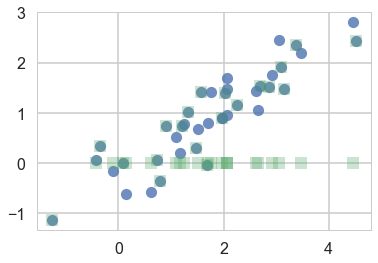

In [4]:
samples_censored=np.copy(samples)
samples_censored[20:,1]=0
plt.plot(samples[:,0], samples[:,1], 'o', alpha=0.8)
plt.plot(samples_censored[:,0], samples_censored[:,1], 's', alpha=0.3)


We would use MLE if we had all the data. 

![](images/gform2.png)

In [5]:
mu1 = lambda s: np.mean(s[:,0])
mu2 = lambda s: np.mean(s[:,1])
s1 = lambda s: np.std(s[:,0])
s2 = lambda s: np.std(s[:,1])
rho = lambda s: np.mean((s[:,0] - mu1(s))*(s[:,1] - mu2(s)))/(s1(s)*s2(s))

But we dont. So we shall follow an iterative process to find them.

In [6]:
mu1s=[]
mu2s=[]
s1s=[]
s2s=[]
rhos=[]

Bur remember our data are missing in the y-direction. Assume 0 and go. Since we are using the MLE of the **full-data** likelihood, with this assumption we can use the MLE formulae. This is called M-step or maximization step since we used the MLE formulae.

In [7]:
mu1s.append(mu1(samples_censored))
mu2s.append(mu2(samples_censored))
s1s.append(s1(samples_censored))
s2s.append(s2(samples_censored))
rhos.append(rho(samples_censored))
mu1s,mu2s,s1s,s2s,rhos

([1.7547657491036741],
 [0.44394554402533365],
 [1.2718969990037354],
 [0.77180100755764103],
 [0.52348014627786521])

Now having new estimates of our parameters due to our (fake) y-data, lets go in the other direction. Using these parameters let us calculate new y-values.

One way we might do this is to replace the old-missing-y values with the means of these fixing the parameters of the multi-variate normal and the non-missing data. In other words:

$$E_{p(z \vert \theta, x)}[z]$$

where we have used the notation $z$ to refer to the missing values.

This **posterior** distribution (in the sense of bayes theorem, not bayesian analysis) for the multi-variate gaussian is a gaussian..see [wikipedia](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions) for the formulae

$$\bar{y}(t+1) - \hat{\mu_2}(t) = \hat{\rho}(t)\frac{\hat{\sigma_2}(t)}{\hat{\sigma_1}(t)} \left( \bar{x} - \hat{\mu_1}(t) \right)$$

In [8]:
def ynew(x, mu1, mu2, s1, s2, rho):
    return mu2 + rho*(s2/s1)*(x - mu1)
    

In [9]:
newys=ynew(samples_censored[20:,0], mu1s[0], mu2s[0], s1s[0], s2s[0], rhos[0])
newys

array([-0.25149771,  0.71551635,  0.81675223,  0.85921124,  0.08168773,
       -0.14712658,  0.7300238 ,  0.42993898,  0.51504132,  0.28024916,
       -0.06713977,  0.44793596,  0.54224183,  1.30632573,  0.23563191,
        0.5396655 ,  0.25878933,  0.36945243,  0.99094696,  0.53980901])

This is called the E-step as it computes an expectation for us. Lets run this iteratively and see if we converge.

In [10]:
for step in range(1,20):
    samples_censored[20:,1] = newys
    #M-step
    mu1s.append(mu1(samples_censored))
    mu2s.append(mu2(samples_censored))
    s1s.append(s1(samples_censored))
    s2s.append(s2(samples_censored))
    rhos.append(rho(samples_censored))
    #E-step
    newys=ynew(samples_censored[20:,0], mu1s[step], mu2s[step], s1s[step], s2s[step], rhos[step])
df=pd.DataFrame.from_dict(dict(mu1=mu1s, mu2=mu2s, s1=s1s, s2=s2s, rho=rhos))
df

,mu1,mu2,rho,s1,s2
0,1.754766,0.443946,0.523480,1.271897,0.771801
1,1.754766,0.673782,0.822228,1.271897,0.718523
2,1.754766,0.792335,0.904408,1.271897,0.749225
3,1.754766,0.853302,0.925737,1.271897,0.775802
4,1.754766,0.884575,0.932120,1.271897,0.790958
5,1.754766,0.900583,0.934331,1.271897,0.798740
6,1.754766,0.908762,0.935193,1.271897,0.802589
7,1.754766,0.912935,0.935558,1.271897,0.804467
8,1.754766,0.915062,0.935723,1.271897,0.805378
9,1.754766,0.916144,0.935799,1.271897,0.805821


Voila. We converge to stable values of our parameters.

But they may not be the ones we seeded the samples with. The Em algorithm is only good upto finding local minima, and a finite sample size also means that the minimum found can be slightly different.

## The EM algorithm

** Expectation-maximization (EM)** method is an iterative method for maximizing difficult 
likelihood (or posterior) problems. It was first introduced by Dempster, Laird, and Rubin (1977). 

EM recognizes that if the data were fully observed, then  ML/ MAP estimates would be easy to compute. It thus alternates between inferring the missing values given the parameters (E step), and then optimizing the parameters given the “filled in” data (M step). 
The idea is to find a lower-bound 
on the log-likelihood $\ell$ (E-step) and the optimize the lower-bound (M-step). 

**We want to use EM wherever we dont know how to optimize simply the x-data likelihood.**

The EM algorithm is naturally useful for missing data, truncated data, censored data and grouped data problems. But it is also useful at places where you have clusters like mixture models, and you are working in an unsupervised or semi-supervised mode. Basically, any place you can set up a latent variable model or a data augmentation procedure, EM is useful.

There are applications in astronomical image analysis, genetics, engineering, etc

The basic idea is:

**calculate MLE estimates for the incomplete data problem by using the complete-data likelihood. To create complete data, augment the observed data with manufactured data**

Sorta like, just assign points to clusters to start with and iterate.

Then, at each iteration, replace the augmented data by its conditional expectation given current observed data and parameter estimates. (E-step) Maximize the full-data likelihood to do the M-step.



## Why does EM work?

To understand why EM works we will start with our old friend the KL-divergence. All images in this section are stolen from Bishop

We cast the problem as a MLE problem, but in general any problem in which there is a $\theta, x, z$ triad will work.

We start with:

$$p(x) = \sum_z p(x, z)$$

Specifically, lets cast these as likelihoods

$$p(x \vert \theta) = \sum_z p(x, z \vert \theta)$$

where the $x$ and $z$ range over the multiple points in your data set.

Then $$\ell( x \vert \theta) = log\, p(x \vert \theta) = log\, \sum_z p(x, z \vert \theta)$$

Assume $z$ has some normalized distribution:

$$z \sim q(z)$$.

We wish to compute conditional expectations of the type:

$$E_{p(z \vert x, \theta)}[z]$$

but we dont know this "posterior". Lets however say that we somehow know $q$ and thus can define our loss function as the KL-divergence between $q$ and the posterior $p(z \vert x, \theta)$, henceforth abbreviated $p$.

Then (notice new notation to be consistent with Bishop):

$$ \mathrm{KL}(q \vert\vert p) = D_{KL}(q, p) = E_q[log \frac{q}{p}] = -E_q[log \frac{p}{q}]$$

$$D_{KL}(q, p) = -E_q[log \frac{p(x, z \vert \theta)}{q\,p(x \vert \theta)}]$$

where we have used Bayes Theorem.

Now at first blush this does not seem to have bought us anything as we dont know the full data likelihood and we dont know how to optimize the x-data likelihood. But lets persevere:

$$D_{KL}(q, p) = - \left( E_q[log \frac{p(x, z \vert \theta)}{q}] - E_q[log\,p(x \vert \theta)] \right)$$

The second term does not depend on $q$, and $q$ is normalized so the expectation just gives 1 and we can rewrite the equation in terns of the x-data log likelihoood thus:

$$log\,p(x \vert \theta) = E_q[log \frac{p(x, z \vert \theta)}{q}] + D_{KL}(q, p)$$

If we define the ELBO or Evidence Lower bound as:

$$\mathcal{L}(q, \theta) = E_q[log \frac{p(x, z \vert \theta)}{q}]$$

, then

$log\,p(x \vert \theta)$ = ELBO + KL-divergence

a situation made clear in the diagram below where the ELBO goues upto the blue line and the divergence from the blue to the red. Be careful with the p's, the one on the right is for the x-data and the one on the left for the latent-variable posterior.

![](images/klsplitup.png)

Now recall that the Kullback Liebler divergence is 0 only if the distributions as a function of $z$ are the same at every poiny; it is otherwise **ALWAYS** greater than 0. This tells us that the quantity $\mathcal{L}(q, \theta)$, is **ALWAYS** smaller than or equal to the log-likelihood of $p(x  \vert  \theta)$, as illustrated above. In other words, $\mathcal{L}(q, \theta)$ is a lower bound on the log-likelihood. This is why its called the ELBO, with the "evidence" aspect of it coming from Variational calculus (next lecture).

The ELBO itself is the expected value of the full-data log-likelihood minus the entropy of $q$:

$$\mathcal{L}(q, \theta) = E_q[log \frac{p(x, z \vert \theta)}{q}] = E_q[log p(x, z \vert \theta)] - E_q[log\, q]$$

### E-step

These observations set up the EM algorithm for us. If we choose, in the **E-step**, at some (possibly initial) value of the parameters $\theta_{old}$,

$$q(z) = p(z  \vert  x, \theta_{old}),$$ 

we then set the Kullback Liebler divergence to 0, and thus $\mathcal{L}(q, \theta)$ to the log-likelihood at $\theta_{old}$,  and maximizing the lower bound. 

Using this missing data posterior, conditioned on observed data, and $\theta_{old}$, we compute the expectation of the missing data with respect to the posterior and use it later.

![](images/klsplitestep.png)

### Now the **M-step**. 

Since after the E-step, the lower bound touches the log-likelihood, any maximization of this ELBO from its current value with respect to $\theta$ will also “push up” on the likelihood itself. Thus M step guaranteedly modifies the parameters $\theta$ to increase (or keep same) the likelihood of the observed data.

Thus we hold now the distribution $q(z)$ fixed at the hidden variable posterior calculated at $\theta_{old}$, and maximize $\mathcal{L}(q, \theta)$ with respect to $\theta$ to obtain new parameter values $\theta_{new}$. This is a regular maximization.

The distribution $q$, calculated as it is at $\theta_{old}$ will not in general equal the new posterior distribution $p(z \vert x,\theta_{new})$, and hence there will be a nonzero KL divergence. Thus the increase in the log-likelihood will be greater than the increase in the lower bound $\mathcal{L}$, as illustrated below.

The M in “M-step” and “EM” stands for “maximization”.

![](images/klsplitmstep.png)

### The process

Note that since $\mathcal{L}$ is maximized with respect to $\theta$, one can equivalently maximize the expectation of the full-data log likelihood $\mathrm{E_q[\ell( x,z  \vert  \theta)]}$ in the M-step since the difference is purely a function of $q$. Furthermore, if the joint distribution $p(x, z \vert  \theta)$ is a member of the exponential family, the log-likelihood will have a particularly simple form and will lead to a much simpler maximization than that of the incomple-data log-likelihood $p(x \vert \theta)$.

We now set $\theta_{old} = \theta_{new}$ and repeat the process. This **EM algorithm** is presented and  illustrated below:

![](images/emupdate.png)

1. We start with the log-likelihood $p(x  \vert  \theta)$(red curve) and the initial guess $\theta_{old}$ of the parameter values
2. Until convergence (the $\theta$ values dont change too much):
    1. E-step: Evaluate the hidden variable posterior $q(z, \theta_{old}) = p(z  \vert  x, \theta_{old})$ which gives rise to a lower bound function of $\theta$: $\mathcal{L}(q(z, \theta_{old}), \theta)$(blue curve) whose value equals the value of $p(x  \vert  \theta)$ at $\theta_{old}$.
    2. M-step: maximize the lower bound function with respect to $\theta$ to get $\theta_{new}$.
    3. Set $\theta_{old} = \theta_{new}$
    
One iteration more is illustrated above, where the subsequent E-step constructs a new lower-bound function that is tangential to the log-likelihood at $\theta_{new}$, and whose value at $\theta_{new}$ is higher than the lower bound at $\theta_{old}$ from the previous step.

Thus

$$\ell(\theta_{t+1}) \ge \mathcal{L}(q(z,\theta_t), \theta_{t+1}) \ge \mathcal{L}(q(z,\theta_t), \theta_{t}) = \ell(\theta_t)$$

The first equality follows since $\mathcal{L}$ is a lower bound on $\ell$, the second from the M-step's maximization of $\mathcal{L}$, and the last from the vanishing of the KL-divergence after the E-step. As a consequence, you **must** observe monotonic increase of the observed-data log likelihood $\ell$ across iterations. **This is a  powerful debugging tool for your code**.

Note that as shown above, since each EM iteration can only improve the likelihood, you are guaranteeing convergence to a local maximum. Because it **IS** local , you must try some different initial values of $\theta_{old}$ and take the one that gives you the largest $\ell$.

## The EM algorithm with indices laid out

I often find it confusing as to what the indices are actually doing if I dont write them out explicitly. So lets visit the EM derivation once more, focussing on mixtures, and explicitly writing out indices. The derivation does not need mixtures, but I find it helpful to imagine that we are fitting such a model.

Suppose we have an estimation problem in which we have data consising of $m$ independent examples $\{x_1,\ldots,x_m\}$ . 
The goal is to fit the parameters of the model, where the log-likelihood is given by 
\begin{eqnarray}
\ell(x  \vert  \theta)&=& \log \prod_{i=1}^{m} p(x_i \vert  \theta) =   \sum_{i=1}^{m} \log \,p(x_i \vert  \theta)  \\ 
   &=& \sum_{i=1}^{m} \log \zsumi \,p(x_i,z \vert  \theta)  \\ 
\end{eqnarray}

where the $z$ are the latent random variables. If $z$ were observed then the maximum likelihood estimation would be easy. 

Indeed then, let us start with the full data log-likelihood, 

$$\ell(x, z  \vert  \theta) = \sum_{i=1}^{m}  \log \,p(x_i, z_i  \vert  \theta),$$

 which is the log-likelihood we'd calculate if we knew all the $z_i$. But we do not know thse, so lets assume the $\{z_i\}$ have some normalized distribution $q(z)$, and calculate the expected value of the full data log likelihood with respect to this distribution:


\begin{eqnarray}
\mathrm{E_q[\ell( x,z  \vert  \theta)]}  &=& \sum_i \zsumi q_{i}(z_i) \log \,p(x_i, z_i  \vert  \theta)\\
    &=& \sum_i \zsumi q_{i}(z_i) \log \,\frac{p(x_i, z_i  \vert  \theta)}{q_{i}(z_i)} +  \sum_i \zsumi q_{i}(z_i) \log \,q_{i}(z_i)
\end{eqnarray}

The second term only involves $q$ and is independent of $\theta$. Looking only at the first term inside the i-summation:

\begin{eqnarray}
\mathcal{L}(i, q, \theta) &=&  \zsumi q_{i}(z_i) \log \,\frac{p(x_i, z_i  \vert  \theta)}{q_{i}(z_i)} \\
&=& \zsumi  q_i(z_i) \left( \log \frac{p(z_i \vert  x_i,  \theta)}{ q_i(z_i)} + \log p(x_i  \vert  \theta)\right)
\end{eqnarray}

we can see that, since $\zsumi q_i(z_i) = 1$:

\begin{eqnarray}
\mathcal{L}(i, q, \theta) &=& \zsumi  q_i(z_i) \left( \log \frac{p(z_i \vert  x_i,  \theta)}{ q_i(z_i)} + \log p(x_i  \vert  \theta)\right)\\
    &=& -\mathrm{KL}\left(q_i  \vert  \vert  p_i \right) + \log p(x_i  \vert  \theta)\\
\end{eqnarray}

where $\mathrm{KL}$ is the Kullback-Leibler divergence between $q(x)$ and the hidden variable posterior distribution $p(z \vert x,\theta)$ at the poin $i$.

Since the sum over the data-points of the second term is just the log-likelihood we desire, it can then can be written as:

\begin{eqnarray}
\ell(x  \vert  \theta) &=& \sum_i \left(\mathcal{L}(i, q, \theta) +\mathrm{KL}\left(q_i   \vert  \vert  p_i \right)\right)\\
&=& \mathcal{L}(q, \theta) + \mathrm{KL}\left(q  \vert  \vert  p \right)
\end{eqnarray}

where we are defining:

$$\mathrm{KL}(q  \vert  \vert  p) = \sum_i \mathrm{KL}\left(q_i   \vert  \vert  p_i \right)$$

as the sum of the KL-divergence at each data point, and $\mathcal{L}(q, \theta)$ as the sum of $\mathcal{L}$ at each data point.

## The Gaussian Mixture model using EM

We dont know how to solve for the MLE of the unsupervised problem. The EM algorithm comes to the rescue. As described above here is the algorithm:


* Repeat until convergence 
*  E-step: For each $i,j$ calculate 

$$ w_{i,j} = q_i(z_i=j)=p(z_i=j \vert  x_i, \lambda, \mu, \Sigma) $$
     
* M-step: We need to maximize, with respect to our parameters the
  
$$
\begin{eqnarray}
 \mathcal{L} &=& \sum_i \sum_{z_i} q_i(z_i) \log \frac{p(x_i,z_i  \vert \lambda, \mu, \Sigma)}{q_i(z_i)} \nonumber \\
 \mathcal{L} &=& \sum_i \sum_{j=i}^{k}  q_i(z_i=j) \log \frac{p(x_i \vert z_i=j , \mu, \Sigma) p(z_i=j \vert \lambda)}{q_i(z_i=j)} \\
 \mathcal{L} & =&  \sum_{i=1}^{m} \sum_{j=i}^{k} w_{i,j}  \log \left[   \frac{ \frac{1}{ (2\pi)^{n/2} \vert \Sigma_j \vert ^{1/2}} \exp \left(    -\frac{1}{2}(x_i-\mu_j)^T \Sigma_j^{-1} (x_i-\mu_j) \right)  \, \lambda_j   }{w_{i,j}}\right]
\end{eqnarray}
$$

Taking the derivatives yields the following updating formulas:

$$
\begin{eqnarray}
 \lambda_j &=& \frac{1}{m} \sum_{i=1}^m w_{i,j} \nonumber \\ 
 \mu_j&=& \frac{ \sum_{i=1}^m  w_{i,j} \, x_i}{ \sum_{i=1}^m  w_{i,j}} \nonumber \\ 
 \Sigma_j &=& \frac{ \sum_{i=1}^m  w_{i,j} \, (x_i-\mu_j)(x_i-\mu_j)^T}{ \sum_{i=1}^m  w_{i,j}}
\end{eqnarray}
$$

To calculate the E-step we basically calculating the posterior of the  $z$'s given the $x$'s and the
current estimate of our parameters. We can use Bayes rule 

$$ w_{i,j}= p(z_i=j \vert  x_i, \lambda, \mu, \Sigma) = \frac{p( x_i \vert  z_i=j,  \mu, \Sigma)\, p(z_i=j \vert \lambda)}{\sum_{l=1}^k p(x_i  \vert  z_i=l,  \mu, \Sigma) \, p(z_i=l \vert \lambda)} $$

Where $p(x_i  \vert  z_i =j,  \mu, \Sigma)$ is the density of the Gaussian with mean $\mu_j$ and covariance 
$\Sigma_j$ at $x_i$ and $p(z_i=j \vert  \lambda)$ is simply $\lambda_j$. 
If we to compare these formulas in the M-step with the ones we found in GDA we can see
that are very similar except that instead of using $\delta$ functions we use the $w$'s. Thus the EM algorithm corresponds here to a weighted maximum likelihood and the weights are interpreted as the 'probability' of coming from that Gaussian instead of the deterministic 
$\delta$ functions. Thus we have achived a **soft clustering** (as opposed to k-means in the unsupervised case and classification in the supervised case).

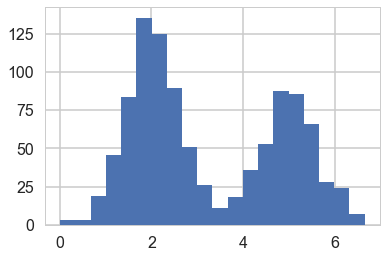

In [11]:
#In 1-D
# True parameter values
mu_true = [2, 5]
sigma_true = [0.6, 0.6]
lambda_true = .4
n = 1000

# Simulate from each distribution according to mixing proportion psi
z = np.random.binomial(1, lambda_true, n)
x = np.array([np.random.normal(mu_true[i], sigma_true[i]) for i in z])

plt.hist(x, bins=20);

In [12]:
#from Bios366 lecture notes
from scipy.stats.distributions import norm

def Estep(x, mu, sigma, lam):
    a = lam * norm.pdf(x, mu[0], sigma[0])
    b = (1. - lam) * norm.pdf(x, mu[1], sigma[1])
    return b / (a + b)



In [13]:
def Mstep(x, w):
    lam = np.mean(1.-w) 
    
    mu = [np.sum((1-w) * x)/np.sum(1-w), np.sum(w * x)/np.sum(w)]
    
    sigma = [np.sqrt(np.sum((1-w) * (x - mu[0])**2)/np.sum(1-w)), 
             np.sqrt(np.sum(w * (x - mu[1])**2)/np.sum(w))]
    
    return mu, sigma, lam

In [52]:
print(lambda_true, mu_true, sigma_true)
# Initialize values
mu = np.random.normal(4, 10, size=2)
sigma = np.random.uniform(0, 5, size=2)
lam = np.random.random()
print("Initials, mu:", mu)
print("Initials, sigma:", sigma)
print("Initials, lam:", lam)

# Stopping criterion
crit = 1e-15

# Convergence flag
converged = False

# Loop until converged
iterations=1


while not converged:
    # E-step
    if np.isnan(mu[0]) or np.isnan(mu[1]) or np.isnan(sigma[0]) or np.isnan(sigma[1]):
        print("Singularity!")
        break
        
    w = Estep(x, mu, sigma, lam)

    # M-step
    mu_new, sigma_new, lam_new = Mstep(x, w)
    
    # Check convergence
    converged = ((np.abs(lam_new - lam) < crit) 
                 & np.all(np.abs((np.array(mu_new) - np.array(mu)) < crit))
                 & np.all(np.abs((np.array(sigma_new) - np.array(sigma)) < crit)))
    mu, sigma, lam = mu_new, sigma_new, lam_new
    iterations +=1           

print("Iterations", iterations)
print('A: N({0:.4f}, {1:.4f})\nB: N({2:.4f}, {3:.4f})\nlam: {4:.4f}'.format(
                        mu_new[0], sigma_new[0], mu_new[1], sigma_new[1], lam_new))

0.4 [2, 5] [0.6, 0.6]
Initials, mu: [  0.72500527 -20.77035111]
Initials, sigma: [ 4.59386658  3.6262629 ]
Initials, lam: 0.6261111131564271
Iterations 95
A: N(5.0083, 0.6288)
B: N(2.0261, 0.5936)
lam: 0.4116


## Why is EM important?

We have motivated the EM algorithm using mixture models and missing data, but that is not its only place of use. 

Since MLE's can overfit, we often prefer to use MAP estimation. EM is a perfectly reasonable method for MAP estimation in mixture models; you just need to multiply in the prior.

Basically the EM algorithm has a similar setup to the data augmentation problem and can be used in any problem which has a similar structure. Suppose for example you have two parameters $\phi$ and $\gamma$ in a posterior estimation, with daya $y$. Say that we'd like to estimate the posterior $p(\phi  \vert  y)$. It may be relatively hard to estimate this, but suppose we can  work with $p(\phi  \vert  \gamma, y)$ and $p(\gamma  \vert  \phi, y)$. Then you can use the structure of the EM algorithm to estimate the marginal posterior of any one parameter. Start with:

$$log p(\phi  \vert  y) = log p(\gamma, \phi  \vert  y) - log p(\gamma  \vert  \phi, y)$$

Notice the similarity of this to the above expressions with $\phi$ as $x$, $y$ as $\theta$, and $\gamma$ as $z$. Thus the same derivations apply toany problem with this structure.

This structure can also be used in type-2 likelihood or emprical bayes estimation.